### 1. К текущему датасету необходимо добавить новый аттрибут

В качестве исследуемого был выбран датасета, аналогичный прошлым работам, с сайта [_kaggle_](https://www.kaggle.com/datasets/rajyellow46/wine-quality "Тыкни на меня").

Новым атрибутом датасета будет **_total_acidity_** -- общая кислотность вина. Атрибут будет рассчитываться следующим образом: **_total_acidity_** = _fixed_acidity_ + _volatile_acidity_.

Ниже загрузим выбранный датасет и добавим туда новый атрибут:

In [46]:
import pandas as pd

path_to_data_set = 'C:/Users/fedos/PycharmProjects/ML-Lab2/winequalityN.csv'
df = pd.read_csv(path_to_data_set)

df['total_acidity'] = df['fixed acidity'] + df['volatile acidity']

### 2. "Причесать" датасет: удалить выбросы и дубли, обработать пропущенные значения, найти кривые данные и т.п.

На этом шаге сначала:

- Удаляем дубликаты.
- Обрабатываем пропуски: если пропусков мало(меньше 5 %), то будем их удалять, в противном случае будем заполнять, чтобы сохранить объем данных, в численных будем заполнять медианой.
- Удаляем выбросы с помощью расчета и выделения IQR.

In [47]:
cols = df.select_dtypes(include=['float64', 'int64']).columns
df_clean = df.copy()
print("Размер до очистки:", df_clean.shape)
df_clean = df_clean.drop_duplicates()

for col in cols:
    missing = df[col].isnull().sum()
    missing_pct = (missing / len(df)) * 100
    if missing_pct >= 5:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)
    else:
        df_clean.dropna(subset=[col], inplace=True)

mask = pd.Series(True, index=df_clean.index)
for col in cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    mask &= (df_clean[col] >= lower) & (df_clean[col] <= upper)

df_clean = df_clean[mask]

print("Размер после очистки:", df_clean.shape)

Размер до очистки: (6497, 14)
Размер после очистки: (4060, 14)


### 3. Построить графики зависимости одной переменной от другой (plt.scatter), описать какие кластеры (группы) вы видите. Построить несколько разных графиков, найти ярковыраженные группы.

Построены графики зависимости для пар:
- volatile acidity и total sulfur dioxide
- citric acid и chlorides
- density и fixed acidity
- chlorides и residual sugar

Лучше всего кластеры видны для пары (volatile acidity и total sulfur dioxide), хуже всего различимы кластеры -- (chlorides и residual sugar). Пары (citric acid и chlorides) и (density и fixed acidity) также имеют хорошо различимые кластеры, но менее выраженные, чем у (volatile acidity и total sulfur dioxide).

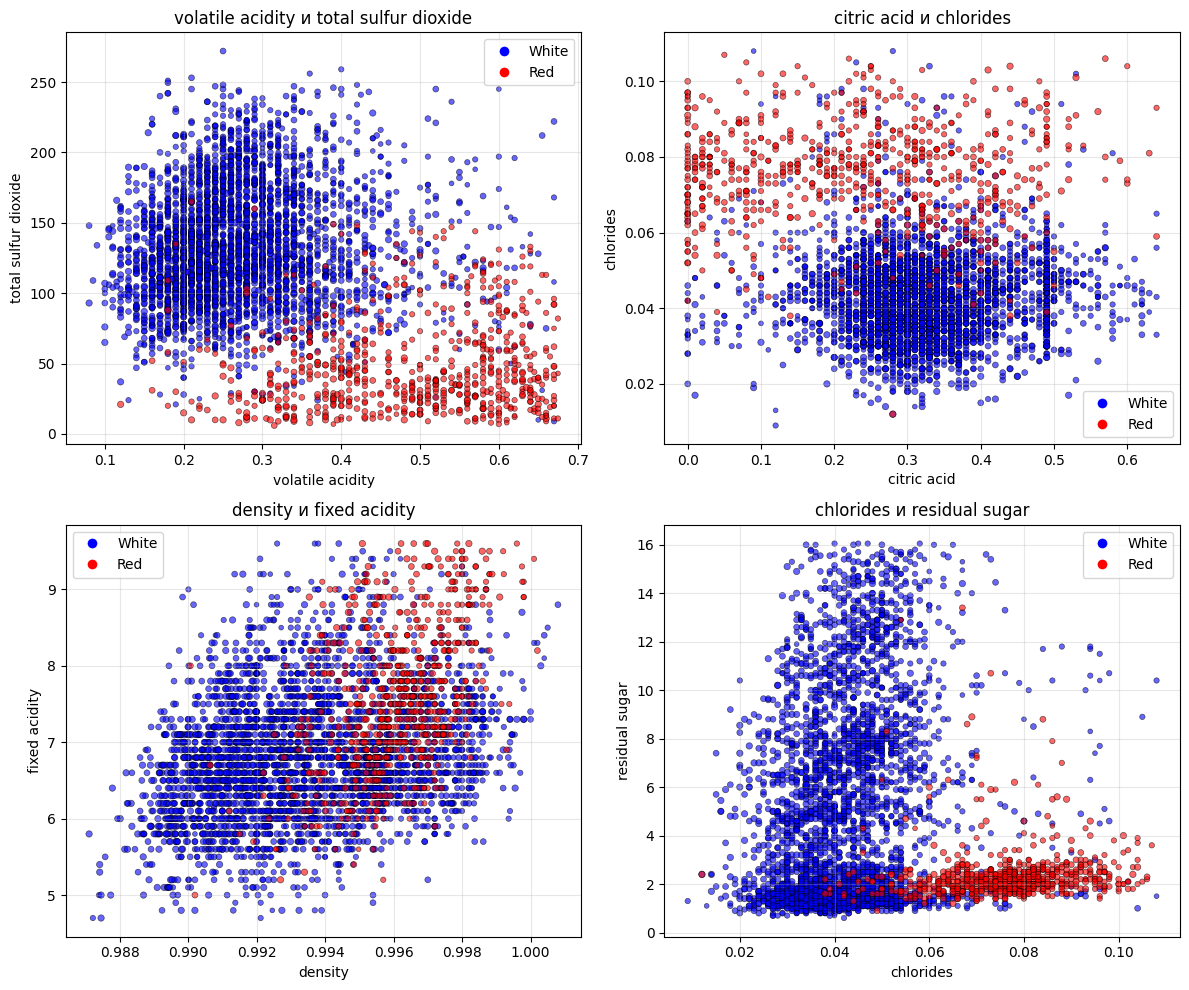

In [48]:
import matplotlib.pyplot as plt

df_clean['type_encoded'] = df_clean['type'].map({'white': 0, 'red': 1})

pairs = [
    ('volatile acidity', 'total sulfur dioxide'),
    ('citric acid', 'chlorides'),
    ('density', 'fixed acidity'),
    ('chlorides', 'residual sugar')
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, (x_col, y_col) in enumerate(pairs):
    ax = axes[i]

    sizes = df_clean['quality'] * 3
    scatter = ax.scatter(df_clean[x_col], df_clean[y_col], c=df_clean['type_encoded'], cmap='bwr',
                         s=sizes, alpha=0.6, edgecolors='black', linewidth=0.5)

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f'{x_col} и {y_col}')
    ax.grid(True, alpha=0.3)

    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='White'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Red')]
    ax.legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()

### 4. Применить метод KMeans к датасету.

Выполним следующие шаги:
- Стандартизуем данные, для этого применим Z-масштабирование.
- Определим гиперпараметр K, при переборе качество кластеризации будем оценивать с помощью коэффициент силуэта, так как число кластеров не фиксированно и будем предполагать, что разметки данных нет.

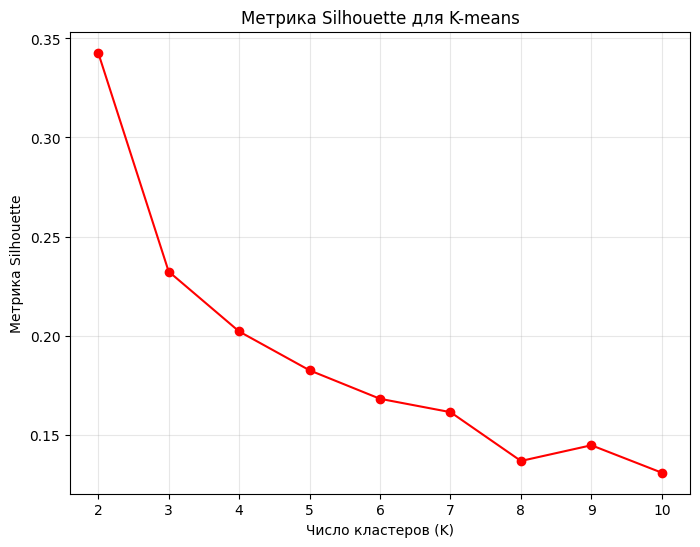

Оптимальное K: 2, Silhouette: 0.343


In [49]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np

X = df_clean.select_dtypes(include=[np.number]).drop('quality', axis=1).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    kmeans.fit(X_scaled)
    sil_score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(sil_score)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, 'ro-')
plt.xlabel('Число кластеров (K)')
plt.ylabel('Метрика Silhouette')
plt.title('Метрика Silhouette для K-means')
plt.grid(True, alpha=0.3)
plt.show()


best_k_idx = np.argmax(silhouette_scores)
best_k = list(range(2, 11))[best_k_idx]
best_score = silhouette_scores[best_k_idx]
print(f'Оптимальное K: {best_k}, Silhouette: {best_score:.3f}')

Далее выполним следующие шаги:
- Выделим кластеры используя подобранный гиперпараметр K.
- Построим графики снизив размерность признакового пространства с помощью PCA до двух компонент, чтобы можно было визуализировать выделенные кластеры. Левый график показывает выделенные кластеры, правый -- предполагаемые кластеры исходя из природы датасета, в нашем случае датасет разделен на красные и белые вина атрибутами _red_ и _white_.

Метрика Silhouette для K=2: 0.343


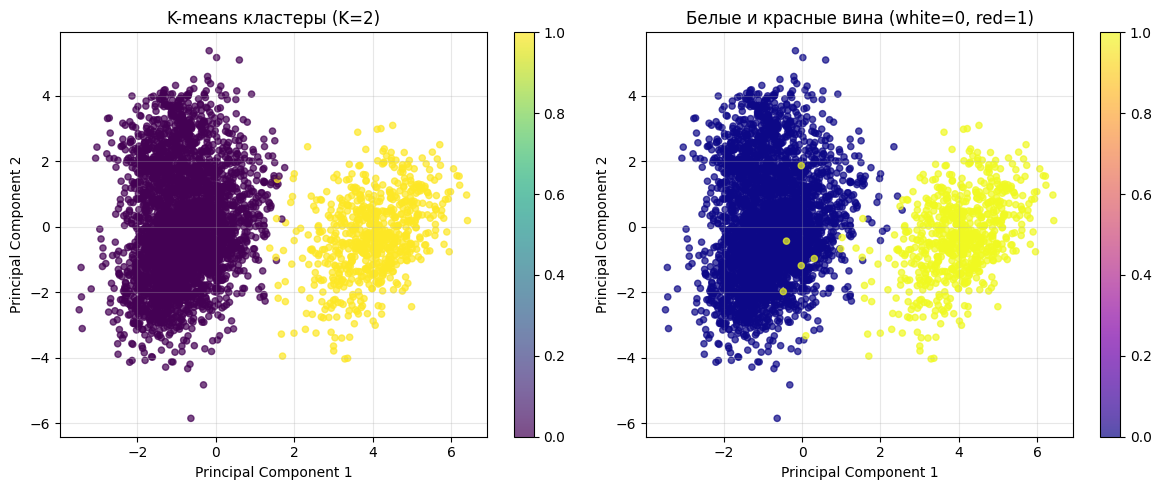

In [51]:
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans.fit(X_scaled)
df_clean['kmeans_cluster'] = kmeans.labels_
final_sil = silhouette_score(X_scaled, kmeans.labels_)
print(f'Метрика Silhouette для K={best_k}: {final_sil:.3f}')

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter1 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_clean['kmeans_cluster'], cmap='viridis', alpha=0.7, s=20)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'K-means кластеры (K={best_k})')
plt.colorbar(scatter1)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
true_type = df_clean['type'].map({'white': 0, 'red': 1}).values
scatter2 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=true_type, cmap='plasma', alpha=0.7, s=20)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Белые и красные вина (white=0, red=1)')
plt.colorbar(scatter2)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5. Написать выводы.

Исходя из полученных графиков и значения коэффициента силуэта можно сделать вывод, что алгоритм хорошо справился со своей задачей выделив правдоподобные кластеры для датасета, что можно увидеть из сравнения с правым графиком. Значение коэффициента силуэта получилось положительным, что говорит о том, что в выделенных кластерах в среднем объекты "родного" кластера оказались ближе к произвольно взятому объекту, чем объекты соседнего кластера.